# Plongement lexical et word embeddings

Ce notebook illustre la technique du "plongement lexical", c'est-à-dire l'apprentissage et la manipulation de représentations vectorielles du texte.

Pour cela, nous nous appuyons sur la technique la plus simple (word2vec) qui permet d'apprendre à associer des mots à des vecteurs (appelés **embeddings**) dans un espace sémantique abstrait.

## Plan du notebook

1. Entraînement du modèle word2vec (découpage des textes en phrases puis en mots, puis apprentissage des représentations vectorielles à partir de notre corpus.)
3. Application 1: similarité sémantique et analogies
4. Application 2: divergences masculin/féminin
5. Application 3: extraction de clusters et représentations visuelles

# 1. Entraînement du modèle word2vec

word2vec "apprend" une représentation vectorielle (spatiale) des mots d'un corpus en entraînant un modèle à accomplir une tâche de prédiction. Ici, la tâche est de prédire les mots entourant un mot donné; par exemple, dans l'expression:

"*climate change simulation*"

Le mot doit apprendre à prédire les mots précédant et suivant "change":

![](output/word2vec_skipgram.png "")

C'est en apprenant à effectuer cette tâche que le modèle apprend simultanément des représentations vectorielles du vocabulaire, qui correspondent en fait à certaines couches internes de l'architecture du réseau de neurones sous-jacent.


Avant tout, commençons par charger les bibliothèques nécessaires :

In [73]:
import nltk
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from tqdm.notebook import tqdm

## Tokenization et extraction des mots

Lors de la séance précédente, nous avons vu qu'une étape préliminaire du traitement automatique des textes était la tokenization, c'est-à-dire le "découpage" des textes en sous-unités linguistiques (par exemple, en phrases, ou en mots).

Ici, nous allons découper chaque titre et résumé d'article en une liste de phrases. Chaque élément de cette liste sera lui-même une liste des mots contenus dans chacune des phrases.

In [74]:
# Initialisation du lemmatizer, qui réduit les mots à leur racine.

lemmatizer = nltk.stem.WordNetLemmatizer()

# Fonction de découpage d'un texte en liste de listes
def text_to_sentences(text):
    # passage du texte en minuscules
    text = text.lower()

    # découpage du texte en liste de phrases
    input_sentences = nltk.tokenize.sent_tokenize(text)

    # initialisation de la liste de listes
    list_of_lists = []

    # tokenization et lemmatization des mots de chaque phrase, une par une
    for sentence in input_sentences:
        # La phrase est convertie en une liste de mots, réduits à leur racine
        # (La fonction tokenize_and_lemmatize est définie plus bas)
        words = tokenize_and_lemmatize(sentence)
        list_of_lists.append(words)
    
    return list_of_lists

# fonction de découpage des phrases en liste de mots
def tokenize_and_lemmatize(sentence):
    # découpage de la phrase en liste de mots
    tokens = nltk.tokenize.word_tokenize(sentence)

    # suppression des mots qui ne contiennent pas uniquement des lettres
    tokens = [t for t in tokens if t.isalpha()]

    # part-of-speech tagging de chaque mot, pour déterminer leur catégorie lexicale
    # (noms, adjectifs, etc.)
    tags = nltk.pos_tag(tokens)

    # On souhaite lemmatizer les mots (réduire à leur forme non conjuguée-non accordée)
    # Ce dictionnaire permet d'adapter la lemmatization selon la catégorie lexicale
    # Par exemple, pour un verbe, la lemmatization consiste à passer à l'infinitif.
    pos_lemma = {
        "J": "a",
        "N": "n",
        "V": "v"
    }

    # Pour chaque mot de la liste, 
    # On retient les mots qui sont des noms, des adjectifs, ou des verbes
    # Et on les lemmatize
    tokens = [
        lemmatizer.lemmatize(word, pos_lemma[pos[0]])
        for word, pos in tags
        if (pos[:2] == "NN" or pos[:2] == "JJ" or pos[:2] == "VB")
    ]
    
    return tokens

On peut tester la fonction :

In [75]:
text_to_sentences("This is a text. It contains multiple sentences.")

[['be', 'text'], ['contain', 'multiple', 'sentence']]

## Chargement des données

In [76]:
# chargement des articles
df = pd.read_parquet("science/climate/articles.parquet")

# chargement des abstracts (résumés des articles)
abstracts = pd.read_parquet("science/climate/abstracts.parquet")

# ajout des abstracts au dataframe des articles
df = df.merge(abstracts, how="inner", left_index=True, right_index=True)

 # retrait des articles de titre ou résumé inconnu/vide
df.dropna(subset=["title", "abstract"], inplace=True)

## Découpage du corpus en liste de phrases

On peut enfin appliquer notre "pipeline" de tokenization à l'ensemble du corpus,
ce qui fournira les données nécessaires à l'entraînement du modèle.

**Attention!** Cette étape prend une quinzaine de minutes sur un ordinateur performant.

In [ ]:
sentences = []
for article in tqdm(df.to_dict(orient="records"), desc="Processing articles"):
    text = article["title"] + ". " + article["abstract"]
    sentences += text_to_sentences(text)

C'est terminé! On peut inspecter une phrase au hasard:

In [ ]:
sentences[10]

## Entraînement du modèle word2vec

Nous utilisons l'implémentation proposée dans la bibliothèque Gensim.
On instancie d'abord un objet Word2Vec:

In [ ]:
model = Word2Vec(
    sentences=sentences, # La liste de phrases, chaque élément de la liste étant lui-même une liste de mots
    vector_size=64,   # Nombre de dimensions des vecteurs dans l'espace sémantique (embeddings)
    window=3,         # Taille de la fenêtre de contexte
    min_count=5,      # Fréquence minimale des mots inclus
    workers=4,        # Nombre de coeurs de processeur utilisés pour l'entraînement
    sg=1,             # Modèle "skip-gram" (pour lequel la tâche est de prédire le contexte entourant chaque mot)
    epochs=1          # Nombre d'itérations d'entraînement: 1 pour commencer
)

On effectue ensuite un certain nombre d'étapes d'apprentissage ("epochs"),
en affichant, à chaque fois, les mots les plus similaires à 3 mots cibles,
afin d'évaluer qualitativement la cohérence du modèle à chaque étape de de son entraînement.

In [ ]:
epochs = 10
for epoch in range(epochs):
    model.train(sentences, total_examples=len(sentences), epochs=1)
    target_words = ["cloud", "pricing", "bayesian"]
    for word in target_words:
        if word in model.wv:
            similar = model.wv.most_similar(word, topn=5)
            print(f"🔹 {word}: " + ", ".join(f"{w} ({s:.2f})" for w, s in similar))
        else:
            print(f"❌ {word} not in vocabulary.")

On peut enregistrer le modèle pour le réutiliser plus tard:

In [ ]:
# model.save("output/word2vec.model")

In [ ]:
# Chargement d'un modèle pré-entraîné
model = Word2Vec.load("output/word2vec.model")

Pour accéder au vecteur associés à un mot, il suffit d'accéder à l'attribut `wv` du modèle :

In [ ]:
model.wv["climate"]

# 2. Similarité sémantique et analogies

## 2.a. Similarité sémantique

Les représentations vectorielles nous permettent d'identifier des relations de proximité sémantique à partir des distances entre les vecteurs associés à chaque mot du vocabulaire. Par exemple, pour identifier les mots les plus similaires à "climat", il suffit de calculer la distance entre les vecteurs de chaque mot du corpus et de filtrer les plus proches. Gensim permet d'effectuer cette tâche facilement. Par exemple, pour observer les 10 mots les plus similaires à "deforestation":

In [ ]:
model.wv.most_similar("deforestation", topn=10)

## 2.b. Analogies

Les analogies dénotent des relations du type, "les rois sont aux hommes ce que les reines sont aux femmes", parfois notées:

$\text{king}:\text{man}::\text{queen}:\text{woman}$

Les représentations vectorielles des mots apprise par la méthode précédente permettent de recouvrir des analogies, qui se traduisent par des équations vectorielles dans l'espace vectoriel sémantique. Par exemple :

$\vec{\text{king}}+\vec{\text{woman}}-\vec{\text{man}}\simeq\vec{\text{queen}}$

![](output/analogies.png "")

Afin d'illustrer la capacité des embeddings à identifier des analogies, considérons le cas des vulnérabilités régionales au changement climatique. Toutes les régions, en effet, ne subiront pas le même genre de conséquences: si la californie est vulnérable aux incendies, qu'en est-il du Bangladesh? Répondre à cette question consiste à identifier le concept manquant dans cette analogie :

$\text{wildfire}:\text{california}::\text{?}:\text{bangladesh}$

Ce qui revient à identifier les concepts les plus similaires au vecteur suivant :

$\vec{\text{wildfire}}+\vec{\text{bangladesh}}-\vec{\text{california}}\simeq \vec{?}$

Cela peut-être fait facilement avec gensim :

In [ ]:
model.wv.most_similar(
    positive=["bangladesh", "wildfires"],
    negative=["california"]
)

On constate alors l'apparition des concepts "flood" et "riverbank", qui suggère que le Bangladesh est plus vulnérable aux inondations et aux crues.

# 3. Divergence masculin/féminin

Dans cette partie, on propose d'exploiter ces représentations vectorielles afin de mieux comprendre la divergence entre les publications majoritairement masculines et majoritairement féminines.

Pour cela, nous procédons en plusieurs étapes:

1. Extraction des mots contenus dans les titres de chaque article
2. Calcul de la proportion d'auteurs de genre féminin et masculin dans chaque article
3. À partir des mots contenus dans les titres de chaque article, construction d'un vecteur sémantique moyen associé à chaque article, en moyennant les embeddings de chacun des mots contenus dans leur titre.
4. Calcul du vecteur sémantique moyen des articles 1) majoritairement masculins ($\vec{m}$) et 2) majoritairement féminins ($\vec{f}$)
5. Récupération des mots les plus similaires au vecteur $\vec{f}-\vec{m}$


In [ ]:
# Récupération des mots de chaque titre
df["title_words"] = df["title"].map(text_to_sentences)

# text_to_sentences() retourne une liste de phrases, chaque phrase étant elle-même une liste de mots;
# mais nous souhaitons une liste liste de mots.
# Par ailleurs, on exclue les mots pour lesquels la représentation vectorielle n'est pas disponible dans le modèle
df["title_words"] = df["title_words"].map(lambda sentences: [
    word
    for sentence in sentences
    for word in sentence
    if word in model.wv
])

# Exclusion des articles contenants peu de mots
df = df[df["title_words"].map(len) >= 2]

Ensuite, on calcule la proportion d'hommes et de femmes dans chaque article :

In [ ]:
authors = pd.read_parquet("science/climate/authors.parquet")
articles_authors = pd.read_parquet("science/climate/articles_authors.parquet")
articles_authors = articles_authors.merge(authors, left_on="author_id", right_index=True)
article_gender = articles_authors.groupby("article_id").agg(
    male = ("gender", lambda g: np.sum(g=="m")),
    female = ("gender", lambda g: np.sum(g=="f"))
)
df = df.merge(article_gender, how="inner", left_index=True, right_index=True)

On calcule un vecteur sémantique moyen associé à chaque article :

In [ ]:
# On définit une fonction transformant une liste de mots en une liste de vecteurs normalisés
# (c'est-à-dire redimensionnés de sorte que leur longueur soit égale à 1, ce qui permet de mieux les comparer)

def words_to_embeddings(words):
    return [
        normalize(model.wv[word])
        for word in words
        if word in model.wv
   ]

# Cela nécessite de définir une fonction normalisant un vecteur pour que sa longueur soit égale à 1
def normalize(v):
    return v/np.linalg.norm(v)

# On ajoute une colonne embeddings au dataframe, qui contient la liste des embeddings de chaque mot des titres des articles
df["embeddings"] = df["title_words"].map(words_to_embeddings)

# Pour moyenner les embeddings de chaque mot, article par article, on définit la fonction suivante:
def average_embedding(embeddings):
    return np.mean(embeddings, axis=0)

# Cela nous donne l'embedding moyen de chaque titre :
df["average_embedding"] = df["embeddings"].map(average_embedding)

In [ ]:
# On sépare les articles majoritairement masculins des articles majoritairement féminins:

male_docs = df[df["male"]>df["female"]]
female_docs = df[df["male"]<df["female"]]

# On calcul leur embedding moyen:
average_male = np.mean(np.stack(male_docs["average_embedding"].values), axis=0)
average_female = np.mean(np.stack(female_docs["average_embedding"].values), axis=0)

# On observe les mots les plus similaires à la différence entre ces deux vecteurs:
model.wv.similar_by_vector(+(normalize(average_female)-normalize(average_male)), topn=20)

# 4. Représentation visuelle et extraction de clusters.

Les représentations vectorielles situent chaque mot dans un "espace" sémantique.
Cet espace peut être représenté sur une carte, offrant une représentation visuelle de la composition d'un corpus.

Lorsque des groupes de mots "proches" les uns des autres
apparaissent dans cet espace sous la forme de "clusters",
cela signalle potentiellement des thématiques ou des sujets parmi un corpus. 
Ainsi, des méthodes de clustering spatialles fondées sur la distance entre vecteurs
peuvent être employées afin de détecter différents sujets dans un corpus.

Pour illustrer ces possibilités, on propose de réaliser une carte des mots du corpus, en mettant en valeur ceux qui appartiennent à des clusters.

On commence par restreindre le vocabulaire aux 25000 mots les plus fréquents du corpus, pour rendre la visualisation plus lisible :


In [ ]:
# construction d'un dictionnaire contenant le nombre d'occurrences de chaque mot dans les titres des articles du corpus
document_frequency = dict()

for words in df["title_words"].tolist():
    for word in set(words):
        document_frequency[word] = document_frequency.get(word, 0)+1

# construction d'une liste contenant tous les mots du vocabulaire
vocabulary = list(document_frequency.keys())

# classement des mots du plus fréquent au moins fréquent
top_words = sorted(
    vocabulary, # liste à trier
    key=lambda x: document_frequency[x], # critère de tri
    reverse=True # ordre (descendant)
)

# On construit une liste blanche constituée des 25000 mots les plus fréquents du vocabulaire (les 25000 premiers éléments de la liste triée)
whitelist = top_words[:25000]

Les 5 premiers mots de la liste blanche sont :

In [ ]:
whitelist[:5]

On souhaite positionner les mots sur une carte.
Pour cela, on commencer par récupérer leurs vecteurs (leurs *embeddings*):

In [ ]:
vectors = [
    model.wv[word]
    for word in whitelist
]

# Affichage du premier vecteur:
vectors[0]

Les *embeddings* de chaque mot possèdent 64 composantes. Il est difficile de représenter un espace à 64 dimensions!
Pour positionner les mots sur un diagramme à deux dimensions, il faut d'abord effectuer une opération de réduction de dimensionalité.

Plusieurs méthodes de réduction de dimensionalité existent, les plus populaires étant:
 - PCA (méthode linéaire bien connue des sociologues)
 - t-SNE
 - Et UMAP, la technique que nous utiliserons.

Pour plus d'information sur le fonctionnement d'UMAP:

 - [https://pair-code.github.io/understanding-umap/index.html](https://pair-code.github.io/understanding-umap/index.html) 
 - [https://pair-code.github.io/understanding-umap/supplement.html](https://pair-code.github.io/understanding-umap/supplement.html)

In [ ]:
import umap

reducer = umap.UMAP(
    n_components=2,
    n_neighbors=30, # nombre maximum de voisins pris en compte
    min_dist=0.1, # distance minimale entre les points après réduction de dimensionalité
    metric="cosine", # mesure de distance entre points
    random_state=42 # l'algorithme n'est pas déterministe : pour assurer des résultats reproductibles, on fixe 
)
embeddings_2d = reducer.fit_transform(vectors)
embeddings_2d[0]

Les vecteurs étant réduits à deux composantes, ils peuvent-être représentés sous la forme d'un scatter plot à deux dimensions.
Pour cela, on utilise la bibliothèque matplotlib:

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))

plt.scatter(
    x = embeddings_2d[:, 0], # abscisses
    y = embeddings_2d[:, 1], # ordonnées
    s = 5, # taille des points
    alpha = 0.1 # opacité des points
)

Pour identifier des clusters dans cette carte, on peut utiliser l'algorithme [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html):

In [ ]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5, # nombre de points minimal dans chaque cluster; plus ce nombre est élevé, plus les clusters seront 'gros'
    metric="euclidean" # mesure de distance 
)
cluster_labels = clusterer.fit_predict(embeddings_2d)
cluster_labels[:10]

Chaque mot se voit attribuer un cluster, identifié par un entier, ou bien aucun cluster (-1), ce qui correspond aux "outliers", qui ne semblent pas rattachés à un cluster spécifique.

On peut alors re-dessiner notre carte, en indiquant les clusters par des couleurs différentes :

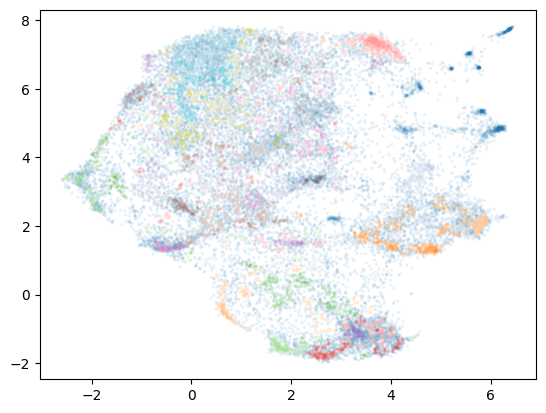

In [78]:
plt.scatter(
    x = embeddings_2d[:, 0],
    y = embeddings_2d[:, 1],
    s = 5,
    alpha = 0.1,
    c = cluster_labels,
    cmap = "tab20",
    edgecolor="none"
)

Pour comprendre cette carte, il est nécessaire de rattacher les points aux mots qu'ils représentent.
Pour qu'elle demeure lisible, on affiche uniquement le mot le plus fréquent associé à chaque cluster :

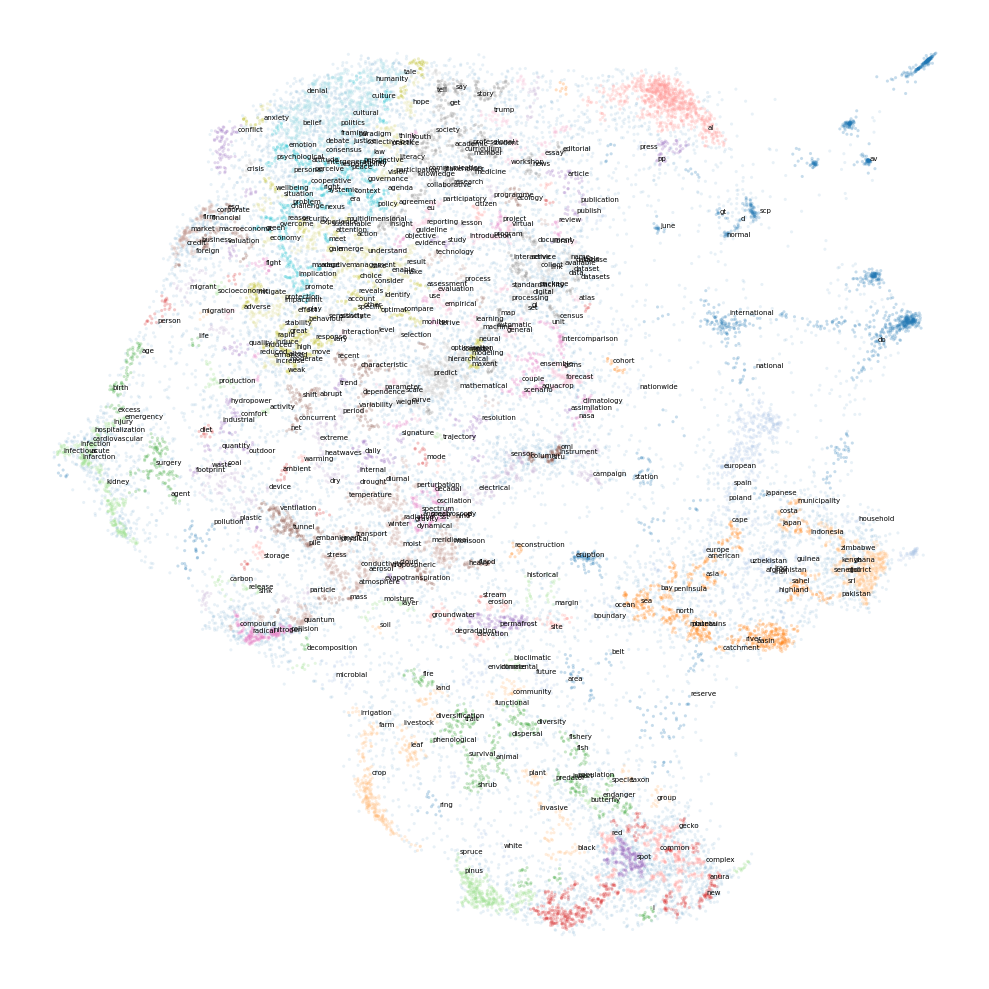

In [82]:
# Création d'une figure
plt.figure(figsize=(10, 10))

# Scatter plot
plt.scatter(
    x=embeddings_2d[:, 0],
    y=embeddings_2d[:, 1],
    s=5,
    edgecolor='none',
    alpha=np.where(cluster_labels==-1, 0.1, 0.25),
    c=cluster_labels,
    cmap="tab20",
)

words = pd.DataFrame({
    "word": whitelist,
    "cluster": cluster_labels,
    "frequency": [document_frequency[x] for x in whitelist],
    "x": embeddings_2d[:, 0],
    "y": embeddings_2d[:, 1],
})

words.sort_values(["cluster", "frequency"], inplace=True, ascending=False)

for word in words.groupby("cluster").head(1).to_dict(orient="records"):
    if word["frequency"] < 100:
        continue
    
    plt.text(word["x"] + 0.01, word["y"] + 0.01, word["word"], fontsize=5)

plt.axis('off')
plt.tight_layout()
plt.savefig("output/map_clusters.pdf")

Une autre façon de représenter la carte est d'employer des couleurs représentant la position de chaque mot sur l'axe féminin-masculin.
Voici une manière de le faire :


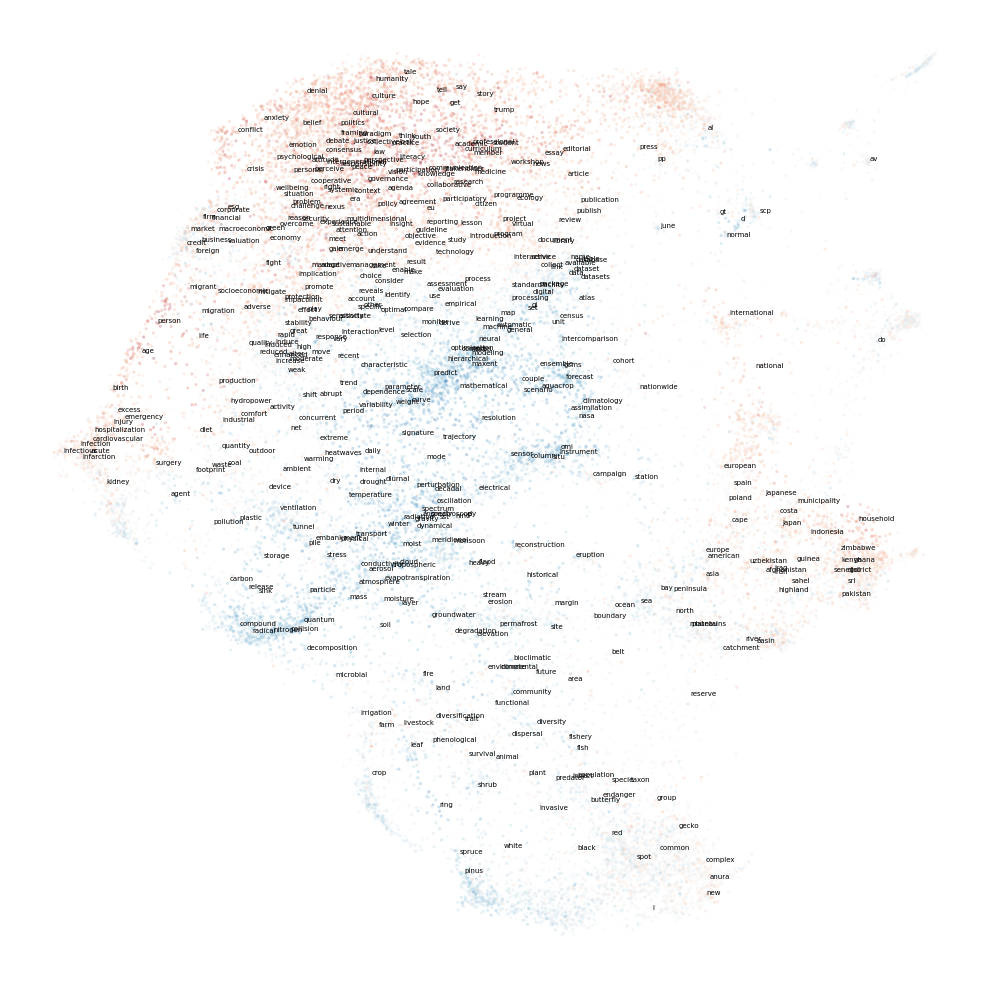

In [83]:
genders = [cosine(average_female-average_male, vector) for vector in vectors]

# Plot the result
plt.figure(figsize=(10, 10))
plt.scatter(
    x=embeddings_2d[:, 0],
    y=embeddings_2d[:, 1],
    s=5,
    edgecolor='none',
    alpha=0.25,
    c=genders,
    cmap="RdBu",
    vmin=np.min(genders),
    vmax=np.max(genders)
)

words = pd.DataFrame({
    "word": whitelist,
    "cluster": cluster_labels,
    "frequency": [document_frequency[x] for x in whitelist],
    "x": embeddings_2d[:, 0],
    "y": embeddings_2d[:, 1],
    "gender": genders,
})

words.sort_values(["cluster", "frequency"], inplace=True, ascending=False)

for word in words.groupby("cluster").head(1).to_dict(orient="records"):
    if word["frequency"] < 100:
        continue
    
    plt.text(word["x"] + 0.01, word["y"] + 0.01, word["word"], fontsize=5)


plt.axis('off')
plt.tight_layout()
plt.savefig("output/map_gender.pdf")